<a href="https://colab.research.google.com/github/gahmed098/MAT411/blob/main/Final_Project_MAT_411.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

Extracting the Data from Yahoo.Finance

In [ ]:
# Download Tesla's stock price data
ticker = "TSLA"
start_date = "2015-01-01"
end_date = "2023-08-31"
tesla_data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the data
print(tesla_data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  14.858000  14.883333  14.217333  14.620667  14.620667  71466000
2015-01-05  14.303333  14.433333  13.810667  14.006000  14.006000  80527500
2015-01-06  14.004000  14.280000  13.614000  14.085333  14.085333  93928500
2015-01-07  14.223333  14.318667  13.985333  14.063333  14.063333  44526000
2015-01-08  14.187333  14.253333  14.000667  14.041333  14.041333  51637500


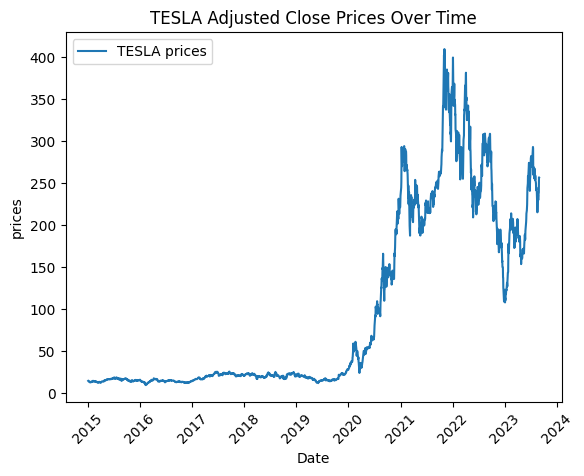

In [ ]:
# Extract adjusted close prices
prices = tesla_data['Adj Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_normalized = scaler.fit_transform(prices)

# Create x-axis values as dates
dates = tesla_data.index

# Plot the data with dates on the x-axis
plt.plot(dates, prices, label="TESLA prices")

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('prices')
plt.title('TESLA Adjusted Close Prices Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Decomposition of Time Series

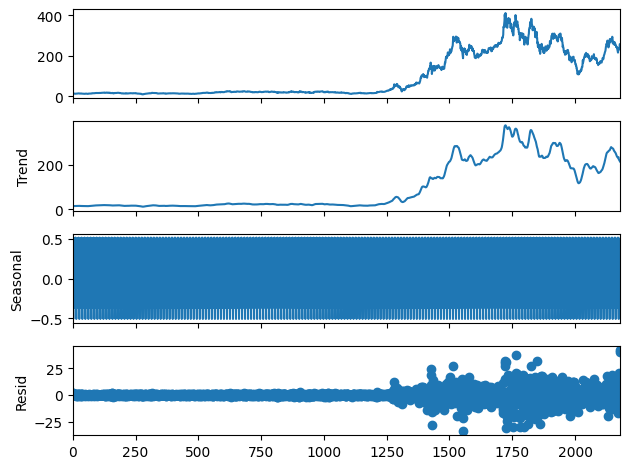

In [ ]:
import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

series = pd.Series(prices.ravel())
df = pd.DataFrame(series)
result = seasonal_decompose(df, model='additive', period=12, extrapolate_trend='freq')
result.plot()
pyplot.show()

Calculating the returns

<ipython-input-7-01ed1c6b5d42>:2: RuntimeWarning: divide by zero encountered in divide
  returns = np.diff(prices_normalized, axis=0) / prices_normalized[:-1]


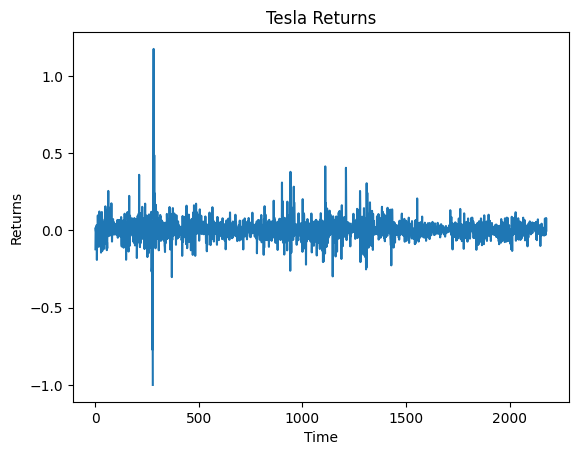

In [ ]:

# Calculate returns
returns = np.diff(prices_normalized, axis=0) / prices_normalized[:-1]

# Handle division by zero or very small values
epsilon = 1e-6  # Small value to avoid division by zero
returns[np.abs(returns) < epsilon] = epsilon

# Convert returns to PyTorch tensor
returns = torch.FloatTensor(returns)

# Plot returns
plt.plot(returns)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Tesla Returns')
plt.show()


Dataloading

In [ ]:
returns = pd.DataFrame(returns.numpy())
# Check for missing values
missing_values = returns.isnull().sum()
print(missing_values)

# Drop rows with missing values
returns.dropna(inplace=True)

# Print the head of the DataFrame
print(returns.head())

0    0
dtype: int64
          0
0 -0.121893
1  0.017916
2 -0.004881
3 -0.004905
4 -0.059149


Data Loading

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(prices_normalized)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

Training

In [ ]:
from torchsummary import summary

# Define hyperparameters
num_epochs = 2000
learning_rate = 0.01
input_size = 1
hidden_size = 2  # Change the hidden size to 2
num_layers = 1
num_classes = 1

# Define the LSTM model class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the LSTM model, loss function, and optimizer
lstm = LSTM(input_size, hidden_size, num_layers, num_classes)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
h_0 = torch.zeros(num_layers, trainX.size(0), hidden_size)
c_0 = torch.zeros(num_layers, trainX.size(0), hidden_size)  # Initialize the cell state tensor
for epoch in range(num_epochs):
    outputs = lstm(trainX)  # Pass both the hidden state and cell state tensors
    optimizer.zero_grad()

    # Obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, Loss: 0.21492
Epoch: 100, Loss: 0.00261
Epoch: 200, Loss: 0.00019
Epoch: 300, Loss: 0.00005
Epoch: 400, Loss: 0.00005
Epoch: 500, Loss: 0.00005
Epoch: 600, Loss: 0.00004
Epoch: 700, Loss: 0.00004
Epoch: 800, Loss: 0.00004
Epoch: 900, Loss: 0.00003
Epoch: 1000, Loss: 0.00003
Epoch: 1100, Loss: 0.00003
Epoch: 1200, Loss: 0.00003
Epoch: 1300, Loss: 0.00003
Epoch: 1400, Loss: 0.00003
Epoch: 1500, Loss: 0.00003
Epoch: 1600, Loss: 0.00003
Epoch: 1700, Loss: 0.00003
Epoch: 1800, Loss: 0.00003
Epoch: 1900, Loss: 0.00003


Training

Testing and prediction

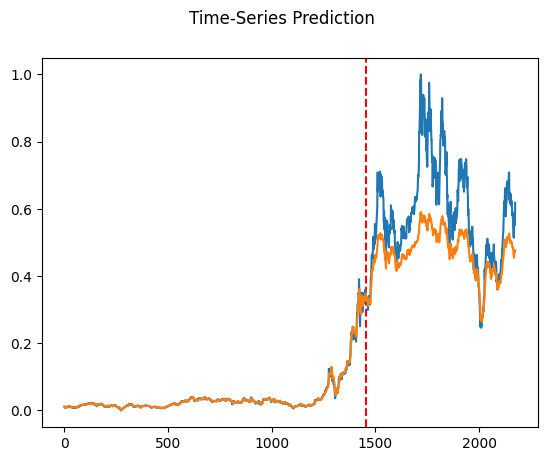

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Model Forecasting

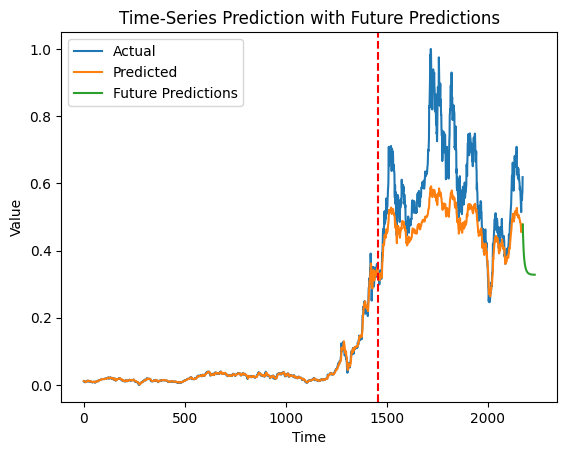

In [ ]:
# Set the model to evaluation mode
lstm.eval()

# Predict values for the input data
train_predict = lstm(dataX)

# Convert the predicted values and actual values to numpy arrays
data_predict = train_predict.cpu().detach().numpy()
dataY_plot = dataY.cpu().detach().numpy()

# Inverse transform the predicted values to original scale
data_predict = sc.inverse_transform(data_predict)

# Plot the actual and predicted values
plt.plot(dataY_plot, label='Actual')
plt.plot(data_predict, label='Predicted')

# Plot additional predicted values for the next 60 time steps
future_predictions = []
# Use the last sequence of dataX as input for predicting future values
future_input = dataX[-1:, :, :]
for _ in range(60):
    # Predict the next value
    future_prediction = lstm(future_input)
    # Append the predicted value to the list
    future_predictions.append(future_prediction.item())
    # Update the input for the next prediction by shifting one step forward
    future_input = torch.cat([future_input[:, 1:, :], future_prediction.unsqueeze(1)], dim=1)

# Inverse transform the future predictions to original scale
future_predictions = sc.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the future predictions
plt.plot(np.arange(len(dataY_plot), len(dataY_plot) + 60), future_predictions, label='Future Predictions')

# Plot vertical line to mark the end of the training data
plt.axvline(x=train_size, c='r', linestyle='--')

# Add labels and title to the plot
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time-Series Prediction with Future Predictions')
plt.legend()
plt.show()


Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse = mean_squared_error(dataY_plot, data_predict)
print('Mean Squared Error (MSE):', mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(dataY_plot, data_predict)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 0.0067454656
Root Mean Squared Error (RMSE): 0.08213078
Mean Absolute Percentage Error (MAPE): inf


<ipython-input-56-30867ea6153e>:15: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
